## Ref

- https://www.kaggle.com/c/web-traffic-time-series-forecasting
- https://www.kaggle.com/screech/ensemble-of-arima-and-lstm-model-for-wiki-pages
- https://www.kaggle.com/arjunsurendran/using-lstm-on-training-data



In [1]:
# ops 
import numpy as np
import pandas as pd 
import datetime as dt
import time
import math 
import re
import matplotlib.pylab as plt



# DL 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D
from keras.callbacks import Callback

Using TensorFlow backend.
/Users/yennanliu/anaconda3/envs/ds_dash/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


## 0) Get data 

In [2]:
train = pd.read_csv('train_1.csv').fillna(0)


## 1) Data Pre-process

In [3]:
# help functions 

def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        """
        ----- fix here for python 3 ----
        https://stackoverflow.com/questions/18493677/how-do-i-return-a-string-from-a-regex-match-in-python
        """
        return res.group(0)[:2]
    return 'na'


def plot_entry(key,idx):
    data = lang_sets[key].iloc[idx,1:]
    fig = plt.figure(1,figsize=(10,5))
    plt.plot(days,data)
    plt.xlabel('day')
    plt.ylabel('views')
    plt.title(train.iloc[lang_sets[key].index[idx],0])
    
    plt.show()


In [4]:
train['lang'] = train.Page.map(get_language)


In [5]:
lang_sets = {}     # get the search data without language column 
lang_sets['en'] = train[train.lang=='en'].iloc[:,0:-1]
lang_sets['ja'] = train[train.lang=='ja'].iloc[:,0:-1]
lang_sets['de'] = train[train.lang=='de'].iloc[:,0:-1]
lang_sets['na'] = train[train.lang=='na'].iloc[:,0:-1]
lang_sets['fr'] = train[train.lang=='fr'].iloc[:,0:-1]
lang_sets['zh'] = train[train.lang=='zh'].iloc[:,0:-1]
lang_sets['ru'] = train[train.lang=='ru'].iloc[:,0:-1]
lang_sets['es'] = train[train.lang=='es'].iloc[:,0:-1]

sums = {}         # avg daily searching (for each language )
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:,1:].sum(axis=0) / lang_sets[key].shape[0]

In [6]:
train.head(3)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,lang
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0,zh
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0,zh
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0,zh


## 2) Simple LSTM model 

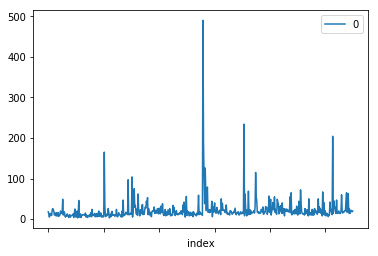

In [7]:
train.iloc[0]\
  .fillna(0)\
  .reset_index()\
  .set_index('index')\
  .iloc[1:-1,:].plot()  # remove language column 

    

en


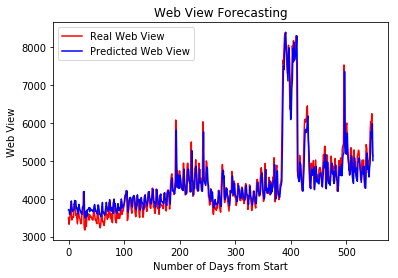

es


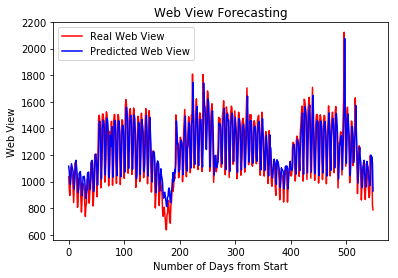

fr


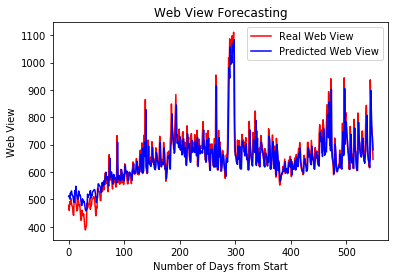

ja


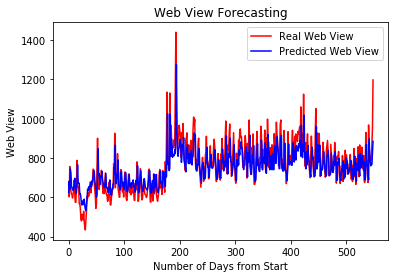

de


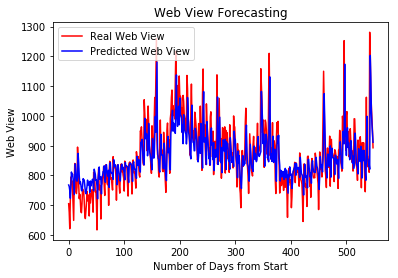

na


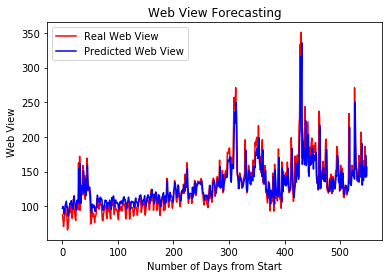

zh


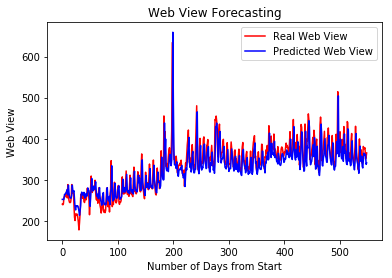

ru


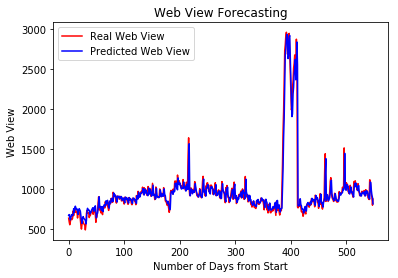

In [12]:
### Here we are predicting "average daily searching (for each language )" ; insead of each single wiki searching  
### TODO : validate if it makes sense to "train LSTM with test data, but doing prediction with whole test + train data" ?    

for key in sums:
    row = [0]*sums[key].shape[0]
    for i in range(sums[key].shape[0]):
        row[i] = sums[key][i]


    #Using Data From Random Row for Training and Testing

    X = row[0:549]
    y = row[1:550]

    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

    # Feature Scaling
    sc = MinMaxScaler()
    X_train = np.reshape(X_train,(-1,1))
    y_train = np.reshape(y_train,(-1,1))
    X_train = sc.fit_transform(X_train)
    y_train = sc.fit_transform(y_train)


    #Training LSTM

    #Reshaping Array
    X_train = np.reshape(X_train, (384,1,1))

    # Initialising the RNN
    regressor = Sequential()

    # Adding the input layerand the LSTM layer
    regressor.add(LSTM(units = 8, activation = 'relu', input_shape = (None, 1)))


    # Adding the output layer
    regressor.add(Dense(units = 1))

    # Compiling the RNN
    regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

    # Fitting the RNN to the Training set
    regressor.fit(X_train, y_train, batch_size = 10, epochs = 100, verbose = 0)

    # Getting the predicted Web View
    
    # --- NEED TO VALIDATE HERE --- #
    
    inputs = X
    inputs = np.reshape(inputs,(-1,1))
    inputs = sc.transform(inputs)
    inputs = np.reshape(inputs, (549,1,1))
    y_pred = regressor.predict(inputs)
    y_pred = sc.inverse_transform(y_pred)
    
    # --- NEED TO VALIDATE HERE --- #
    

    print(key)
    #Visualising Result
    plt.figure
    plt.plot(y, color = 'red', label = 'Real Web View')
    plt.plot(y_pred, color = 'blue', label = 'Predicted Web View')
    plt.title('Web View Forecasting')
    plt.xlabel('Number of Days from Start')
    plt.ylabel('Web View')
    plt.legend()
    plt.show()